The contains a short implementation of learning a dynamics model to mimic a spiral ODE.
Based on:
* https://github.com/rtqichen/torchdiffeq/tree/master/examples

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

keras = tf.keras
tf.enable_eager_execution()

In [3]:
from neural_ode import NeuralODE

# Generate spiral dataset

In [4]:
data_size = 1000
batch_time = 20 # this seems to works the best ...
niters = 3000
batch_size = 16

t_grid = np.linspace(0, 25, data_size)
true_y0 = tf.to_float([[2., 0.]])
true_A = tf.to_float([[-0.1, 2.0], [-2.0, -0.1]])

## Create spiral dataset

In [5]:
class Lambda(tf.keras.Model):
    def call(self, inputs, **kwargs):
        t, r = inputs
        return tf.matmul(r**3, true_A)

Integrate spiral dynamics to obtain trajectory over time

In [6]:
neural_ode = NeuralODE(Lambda(), t=t_grid)
yN, states_history = neural_ode.forward(true_y0, return_states="numpy")

true_y = np.concatenate(states_history)
true_y.shape

(1000, 2)

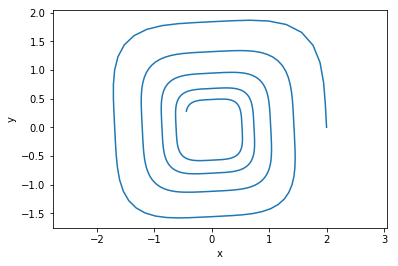

In [7]:
def plot_spiral(trajectories):
    for path in trajectories:
        plt.plot(*path.T)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")

plot_spiral([true_y])

# Matching true end position with predicted one

## Create batch generator

Sample frament of trajectory, here we want to start from some random position `y0`, and then
force model to match final posiion `yN`

In [8]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    batch_y0 = true_y[starts] # (batch_size, 2) -> initial point
    batch_yN = true_y[starts + batch_time]
    return tf.to_float(batch_y0), tf.to_float(batch_yN)

In [10]:
# %timeit get_batch()

127 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Create NeuralODE

## Some neural network

In [9]:
# simple network which is used to learn trajectory
class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(2)        

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y**3
        h = self.linear1(h)
        h = self.linear2(h)
        return h

## NeuralODE integrator with RK4 solver

In [10]:
model = ODEModel()
neural_ode = NeuralODE(model, t = np.linspace(0, 1.0, batch_time))
optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-4)

In [11]:
def compute_gradients_and_update(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_mean(tf.abs(pred_y - batch_yN))
        
    dLoss = g.gradient(loss, pred_y)
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)
    optimizer.apply_gradients(zip(dWeights, model.weights))
    return loss

# Compile EAGER graph to static (this will be much faster)
compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

  0%|          | 0/3000 [00:00<?, ?it/s]

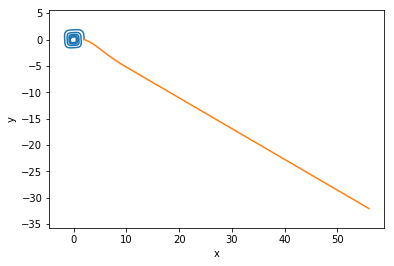

 17%|█▋        | 498/3000 [00:12<01:04, 38.57it/s]

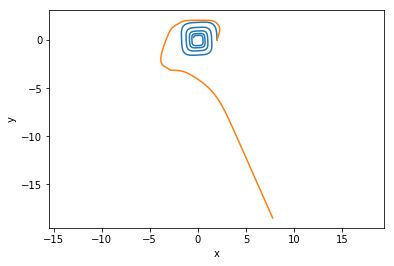

 33%|███▎      | 999/3000 [00:19<00:38, 51.61it/s]

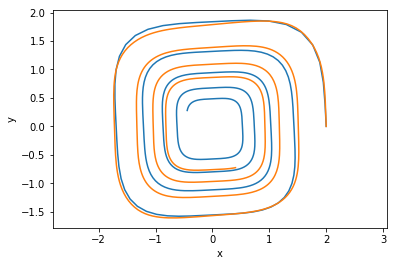

 50%|████▉     | 1498/3000 [00:25<00:26, 57.70it/s]

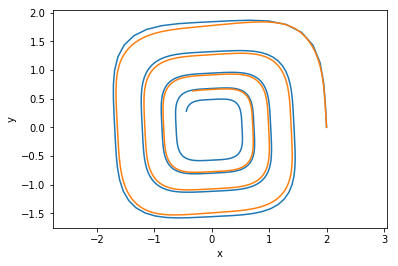

 66%|██████▋   | 1989/3000 [00:32<00:16, 61.22it/s]

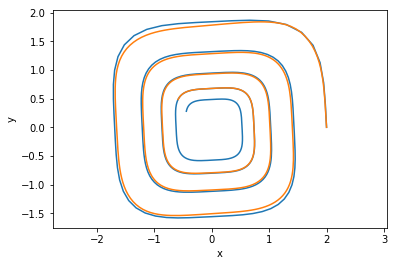

 83%|████████▎ | 2495/3000 [00:38<00:07, 64.36it/s]

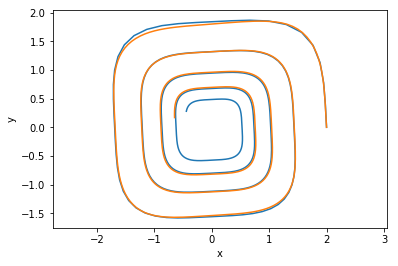

100%|██████████| 3000/3000 [00:45<00:00, 66.01it/s]


In [12]:
# Solver for testing trajectory
neural_ode_test = NeuralODE(model, t=t_grid)

loss_history = []
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_batch()
    loss = compute_gradients_and_update(batch_y0, batch_yN)
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:        
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")
        # plot trajectories        
        plot_spiral([true_y, np.concatenate(states_history_model)])        
        plt.show()

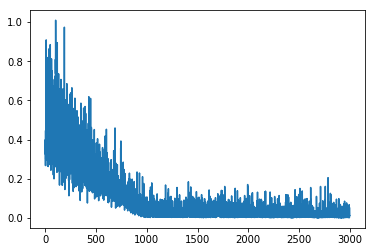

In [16]:
plt.plot(loss_history)

## Extrapolation t > 25

In [17]:
# start from position at t ~ 25
true_yN = tf.to_float([true_y[-100]])

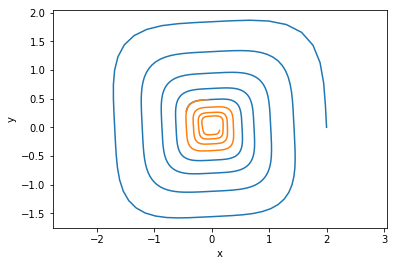

In [18]:
neural_ode_extrapolation =  NeuralODE(model, t = np.linspace(0, 500.0, data_size))
yN, states_history_model = neural_ode_extrapolation.forward(true_yN, return_states="numpy")
plot_spiral([true_y, np.concatenate(states_history_model)])        

# Matching all points along trajectory

Instead of matching only the last position in the batch i.e. target position with predicted 
position, here we match all points along trajectory. <br> This makes problem much easier to learn.
Here we use Tensorflow autograph to compute gradients. Gradients are propagated throught RK4
solver.

In [19]:
def get_path_batch():
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    batch_y0 = true_y[starts] # (batch_size, 2)
    batch_yN = [true_y[starts + i] for i in range(batch_time)] # (batch_time, batch_size, 2)
    return tf.to_float(batch_y0), tf.to_float(batch_yN)

In [20]:
[element.shape.as_list() for element in get_path_batch()]

[[16, 2], [20, 16, 2]]

In [21]:
model = ODEModel()
neural_ode = NeuralODE(model, t = np.linspace(0, 1.0, batch_time))

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, beta2=0.99)

In [26]:
def compute_gradients_and_update_path(batch_y0, batch_yN):
    with tf.GradientTape() as g:
        
        pred_y, y_points = neural_ode.forward(batch_y0, return_states="tf")        
        pred_path = tf.stack(y_points)  # -> (batch_time, batch_size, 2)        
        loss = tf.reduce_mean(tf.abs(pred_path - batch_yN), axis=1) # -> (batch_time, 2)   
        loss = tf.reduce_mean(loss, axis=0)
    
    # backpropagate through solver with tensorflow
    gradients = g.gradient(loss, model.weights)  
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss

compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path)

  0%|          | 0/3000 [00:00<?, ?it/s]

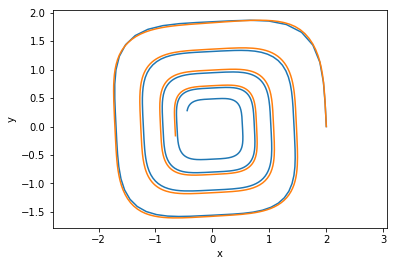

 16%|█▋        | 494/3000 [00:10<00:52, 48.11it/s]

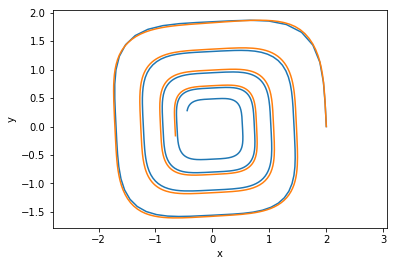

 33%|███▎      | 989/3000 [00:15<00:31, 63.53it/s]

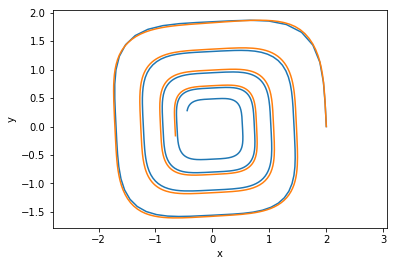

 50%|████▉     | 1490/3000 [00:20<00:21, 71.16it/s]

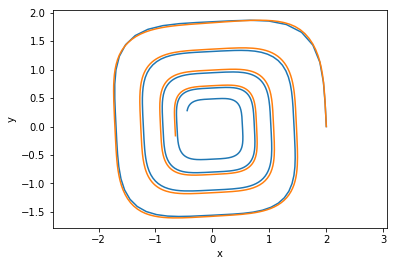

 66%|██████▌   | 1987/3000 [00:26<00:13, 75.83it/s]

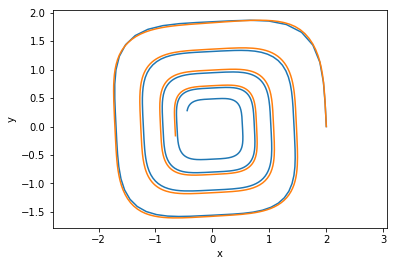

 83%|████████▎ | 2496/3000 [00:31<00:06, 78.71it/s]

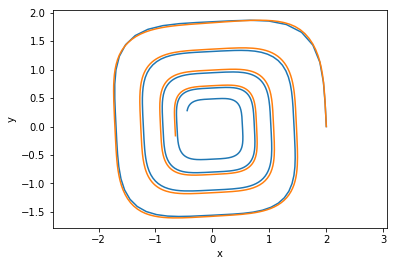

100%|██████████| 3000/3000 [00:37<00:00, 80.80it/s]


In [27]:
loss_history = []
for step in tqdm(range(niters)):
    batch_y0, batch_yN = get_path_batch()
    loss = compute_gradients_and_update_path(batch_y0, batch_yN)    
    loss_history.append(loss.numpy())
    
    if step % 500 == 0:        
        yN, states_history_model = neural_ode_test.forward(true_y0, return_states="numpy")        
        plot_spiral([true_y, np.concatenate(states_history_model)])        
        plt.show()

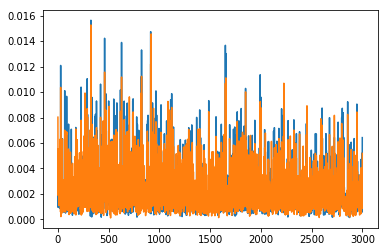

In [28]:
plt.plot(loss_history)

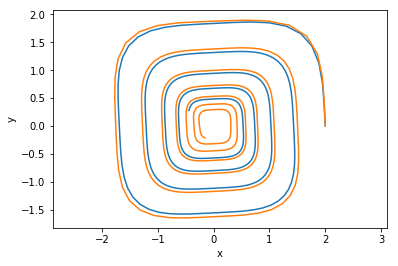

In [30]:
neural_ode_extrapolation =  NeuralODE(model, t = np.linspace(0, 200.0, 3 * data_size))
yN, states_history_model = neural_ode_extrapolation.forward(true_y0, return_states="numpy")
plot_spiral([true_y, np.concatenate(states_history_model)])